In [4]:
from keras.models import *
from keras.layers import *
from keras.callbacks import ModelCheckpoint,CSVLogger
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

np.random.seed(2022)
#5层卷积神经网络
def denoising_ANN():
    input = Input(shape=(None,None,1))
    x =Conv2D(64,3,padding='same')(input)
    x = ReLU()(x)
    for i in range(4):
        x = Conv2D(64,3,padding = 'same',use_bias=False)(x)
        x = BatchNormalization(axis =3,momentum=0.0,epsilon=0.0001)(x)
        x = ReLU()(x)
    x = Conv2D(1,3,padding='same',use_bias=False)(x)
    output = Subtract()([input,x])

    model = Model(inputs=input,outputs=output)
    return model

#设计了一个2D uNET
def unet(pretrained_weights = None,input_size = (None,None,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2,2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2,2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(32, (3,3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(32, (3,3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2,2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(16, (3,3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(16, (3,3), activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, (1,1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[conv8])
    model.summary()
    #model.compile(optimizer = Adam(lr = 1e-4), 
    #    loss = cross_entropy_balanced, metrics = ['accuracy'])
    return model

In [105]:
sample_rows = 128
sample_cols = 64
sample_number = 1000

model_log_dir = f"models_fd"
os.makedirs(model_log_dir,exist_ok=True)

data_X_ID = f"./data/DeepFaultDetection_X_1000x128x64.bin"
data_Y_ID = f"./data/DeepFaultDetection_Y_1000x128x64.bin"

X = np.fromfile(data_X_ID,dtype='float32')
Y = np.fromfile(data_Y_ID,dtype='float32')

X = np.reshape(X,newshape=(sample_number,sample_rows,sample_cols,1))
Y = np.reshape(Y,newshape=(sample_number,sample_rows,sample_cols,1))

#X_train = X[:700]
#Y_train = Y[:700]
#X_val = X[700:990]
#Y_val = Y[700:990]

model = unet(input_size =(None,None,1))

#model = denoising_ANN()

model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


checkpointer = ModelCheckpoint(
    os.path.join(model_log_dir,'model_{epoch:03d}.hdf5'),
    berbose=1,
    period=1)
csv_logger = CSVLogger(os.path.join(model_log_dir,'log.csv'),
append=True,separator=',')

start_time = datetime.datetime.now()


history = model.fit(
    x = X[:700],
    y = Y[:700],
    batch_size=50,
    epochs=50,
    shuffle=True,
    callbacks=[checkpointer,csv_logger],
    validation_data=(X[700:990],Y[700:990])
)

elapsed_time = datetime.datetime.now() - start_time




Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, None, None, 1 160         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, None, None, 1 2320        conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, None, None, 1 0           conv2d_40[0][0]                  
____________________________________________________________________________________________

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

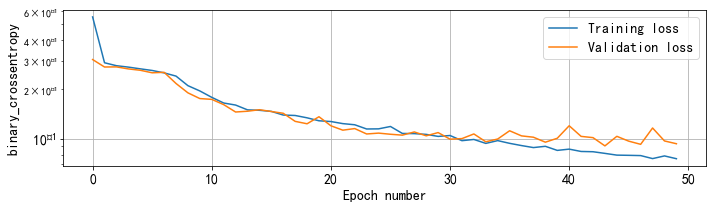

In [106]:
history_dict = history.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
#model.metrics_names

fig, ax = plt.subplots(figsize=(10,3))

ax.semilogy(loss_value, label='Training loss')
ax.semilogy(val_loss_value, label='Validation loss')


ax.set_xlabel('Epoch number', fontsize=14)
ax.set_ylabel('binary_crossentropy', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

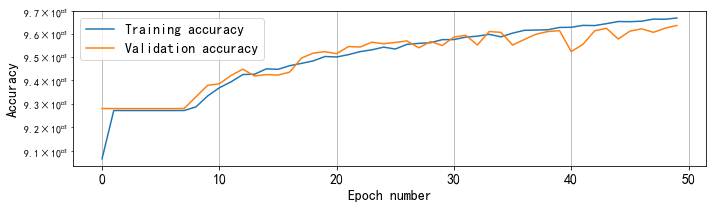

In [107]:
history_dict = history.history
loss_value = history_dict['accuracy']
val_loss_value = history_dict['val_accuracy']
#model.metrics_names

fig, ax = plt.subplots(figsize=(10,3))

ax.semilogy(loss_value, label='Training accuracy')
ax.semilogy(val_loss_value, label='Validation accuracy')


ax.set_xlabel('Epoch number', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()


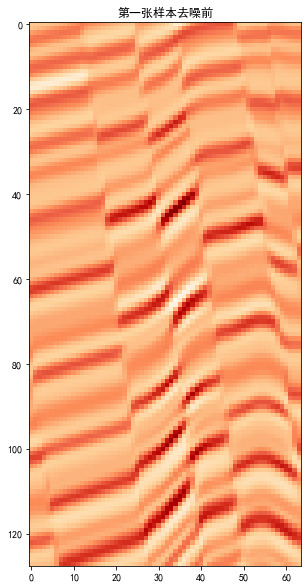

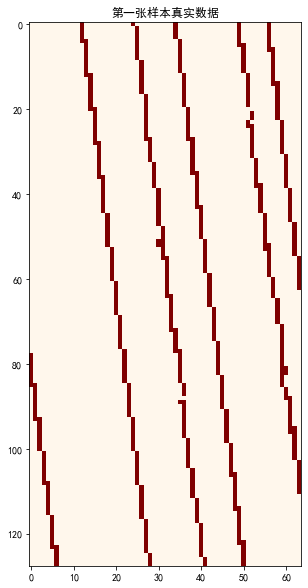

In [9]:
def plot_d(features,title):
    fig = plt.figure()
    fig.set_size_inches(10,10)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
    plt.rcParams['axes.unicode_minus'] = False
    fig.add_subplot(1,1,1)
    plt.imshow(features[:, :, 0], cmap='OrRd', aspect='equal')
    plt.title(title)
plot_d(X[0],title='第一张样本去噪前')
plot_d(Y[0],title = '第一张样本真实数据')

(128, 64, 1)


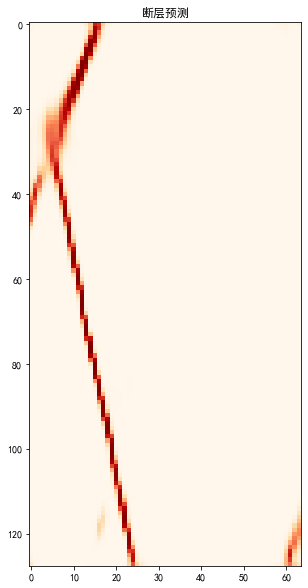

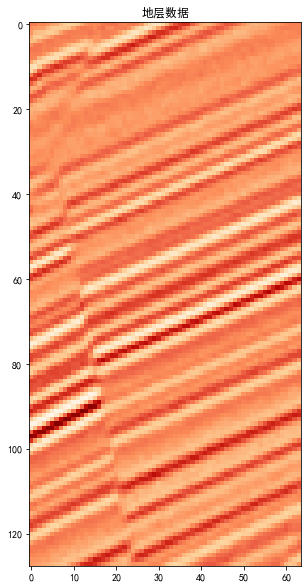

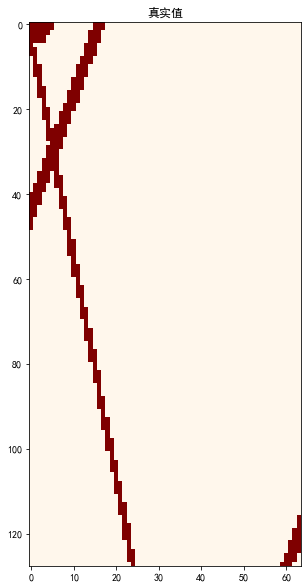

In [117]:
print(X[0].shape)
x_ = model.predict((X[995]).reshape(1,128,64,1)).reshape(128,64,1)

plot_d(x_,title ='断层预测')
plot_d(X[995],title ='地层数据')

plot_d(Y[995],title = '真实值')

w.shape: (3, 3, 16)
第50BATCH，第一卷积层16通道权重可视化


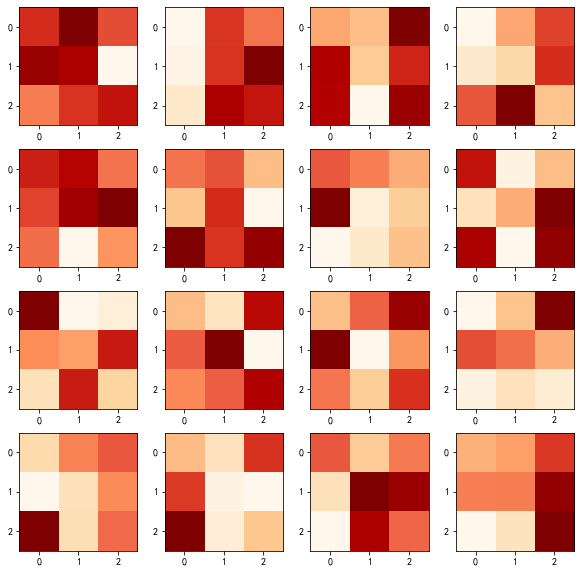

In [126]:
import keras
def plot_w(features,layer_name):
    fig = plt.figure()
    fig.set_size_inches(10,10)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
    plt.rcParams['axes.unicode_minus'] = False
    for i in range(1,17):
        fig.add_subplot(4,4, i )
        plt.imshow(features[:, :, i-1], cmap='OrRd', aspect='equal')
        #plt.title(f'{layer_name}层 第{0 + 1:3d}张特征图')

    

model = keras.models.load_model(f"./models_fd/model_050.hdf5", compile=True)
w = model.layers[1].get_weights()[0].squeeze()
print(f"w.shape: {w.shape}")
fig = plot_w(w, layer_name = '第一卷积层权重')  # 画图
print('第50BATCH，第一卷积层16通道权重可视化')